<a href="https://colab.research.google.com/github/marued/IFT6390/blob/master/11_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks (CNN)

Welcome to the wonderworld of CNNs™. If you followed the last lab session on pytorch, you should already be comfortable with Pytorch's autograd mechanism, and with the standard way to train a model. Today we will focus on convolutional neural nets, aka CNN, aka convnets. On the way, we will also get more familiar with the data loading mechanism from pytorch and the training loop. You have two goals:

1. Overfit a small subset of MNIST. This is a fast and reliable way to test that a model is not garbage.
2. reach the best possible test score on MNIST. Bon courage.

# Réseaux de Neurones Convolutionnels (RNC)
###### C'est un blague, personne n'utilise cet acronyme.

Bienvenu dans le monde merveilleux des CNNs™. Si vous avez suivi la dernière démonstration sur pytorch, vous devriez déjà être à l'aise avec le mécanisme de différentiation automatique, ainsi qu'avec la méthode standard pour entraîner un modèle. Aujourd'hui,  on va s'intéresser à toutes les subtilités des réseaux de neurones convolutionnels. Au passage on va revoir le mécanisme de chargement des données et la boucle d'entraînement. Vous avez deux buts:

1. mémoriser une petite fraction de MNIST avec un modèle. C'est une méthode simple et efficace pour vérifier qu'un modèle est décent.
2. atteindre le meilleur score possible sur MNIST entier. Good luck.



## Set up / Préparation

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x58344000 @  0x7fbf926302a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

print(f"Your version of Pytorch is {torch.__version__}. You should use a version >0.4.")

Your version of Pytorch is 0.4.1. You should use a version >0.4.


In [0]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


## Datasets / Bases de Données

We can use `torchvision`, the vision processing and data library in`PyTorch`, to load `MNIST` more easily. We convert it to a `Tensor` and also normalize the values so our model has an easier time fitting the data

In [0]:
# dataset
from torchvision import datasets, transforms

train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # Standardize with mean and std computed on train set
                       transforms.Normalize((0.1307,), (0.3081,)),
                   ]))

test_data = datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))


Processing...
Done!


In [0]:
# size of the scratch training set TO OVERFIT
n_scratch = 64

# This parameter influences optimization
batch_size = 64
# This is just for evaluation, we want is as big as the GPU can support
batch_size_eval = 512


indices = list(range(len(train_data)))
random.shuffle(indices)

## Data Loading

While `Dataset` holds the data, we use `DataLoader` to choose how we extract the data and turn it into inputs we feed our model.

Our `sampler` class decides how we take the data from the `Dataset`, from shuffling to subsets, see [the docs](https://pytorch.org/docs/stable/data.html) for more info

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import (SubsetRandomSampler,
                                      RandomSampler)

# This is the subset of MNIST we want to overfit
scratch_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    # The sampler is an easy way to say that we're using the elements
    # `indices[:n_scratch]` for this loader
    sampler=SubsetRandomSampler(indices[:n_scratch]),
    num_workers=1,
    pin_memory=use_cuda
)

In [0]:
# TODO: define your own data loader for the train, valid and test dataset 
# where n_valid is how many examples from the training data should be used for validation
n_valid = 15000

test_loader = DataLoader(
    test_data,
    batch_size=batch_size_eval,
    sampler=RandomSampler(test_data),
    num_workers=1,
    pin_memory=use_cuda,
)

valid_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    # The sampler is an easy way to say that we're using the elements
    # `indices[:n_scratch]` for this loader
    sampler=SubsetRandomSampler(indices[:n_valid]),
    num_workers=1,
    pin_memory=use_cuda
)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    # The sampler is an easy way to say that we're using the elements
    # `indices[:n_scratch]` for this loader
    sampler=SubsetRandomSampler(indices[n_valid:]),
    num_workers=1,
    pin_memory=use_cuda
)

# total = len(train_data)
# n_train = total - n_valid
# valid_data, training_data = random_split(train_data, [n_valid, n_train])

In [0]:
for i,j in enumerate([(1,2) , (2, 3), ('a', 'b')]):
  print(j, i)
  

(1, 2) 0
(2, 3) 1
('a', 'b') 2


This is the shape of one batch of inputs torch.Size([64, 1, 28, 28])
This is the shape of one batch of targets torch.Size([64])


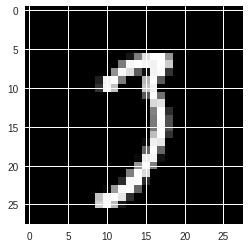

In [0]:
# visualize and understand the data
for inputs, targets in valid_loader:
    print(f"This is the shape of one batch of inputs {inputs.shape}")
    print(f"This is the shape of one batch of targets {targets.shape}")

#           " What is the meaning of each dimension?")
#     print("target", targets.shape, targets)
    img = inputs[0,0]
    plt.imshow(img, cmap='Greys_r')
    break

## Models / Modèles
You can find below a basic CNN. You will have to define your own model a bit later. First let's try to train this one!

Vous avez ci-dessous un CNN élémentaire. Vous devrez définir votre propre modèle un peu plus tard. Pour l'instant essayons déjà d'entraîner celui-ci.

In [0]:
class BasicNet(nn.Module):
    """Affordable convolutions for the people."""
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc = nn.Linear(64*7*7, 10)

    def forward(self, x):
        # x is [batch_size, channels, heigth, width] = [bs, 1, 28, 28]
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2) 
        # x is [bs, 32, 14, 14]
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2) 
        # x is [bs, 64, 7, 7]
        x = x.view(x.size(0), -1) # flatten
        x = F.relu(self.fc(x))
        return x
    

## Training / Entraînement

You have to define general training and testing loops that can be applied to any pytorch module.

Vous devez définir des boucles d'entraînement et de test générales qui s'appliquent à n'importe quel module pytorch.

In [0]:
# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

# spot to save your learning curves, and potentially checkpoint your models
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [0]:
def train(model,train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        # TODO: code this training loop
        loss = torch.tensor([0]) 
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))
            

In [0]:
def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0.1
    
    with torch.no_grad(): # save some computations
      
        for inputs, target in test_loader:
            # TODO: code the evaluation loop
            pass

    test_loss /= test_size
    accuracy = correct / test_size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

In [0]:
model = BasicNet()

lr = 0.0005
optimizer = optim.Adam(model.parameters(), lr=lr)

results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 10):
    train(model, scratch_loader, optimizer, epoch)
    loss, acc = test(model, scratch_loader)
    
    # save results every epoch
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

Train Epoch: 1 [0/64 (0%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 0/0.1 (0%)

Train Epoch: 2 [0/64 (0%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 0/0.1 (0%)

Train Epoch: 3 [0/64 (0%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 0/0.1 (0%)

Train Epoch: 4 [0/64 (0%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 0/0.1 (0%)

Train Epoch: 5 [0/64 (0%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 0/0.1 (0%)

Train Epoch: 6 [0/64 (0%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 0/0.1 (0%)

Train Epoch: 7 [0/64 (0%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 0/0.1 (0%)

Train Epoch: 8 [0/64 (0%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 0/0.1 (0%)

Train Epoch: 9 [0/64 (0%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 0/0.1 (0%)



We have just applied our basic model on scratch_loader. A decent convnet with good parameters should be able to overfit this data easily.
What happened ? What do you conclude ?

On viens d'entraîner notre convnet de base sur scratch_loader. Un modèle décent devrait être capable de mémoriser ce dataset aisément. Que s'est-il passé? Qu'en concluez vous?


## Build your model

It's time to implement your own models to get the best clasification performance on MNIST.
First, try to overfit scratch_loader, for larger and larger sizes. Once you succeed, replace it by the real loaders and classify these digits!
You may consider the following ideas, ranked by relevance:

* batch norm
* more layers
* skip connections
* dropout (on the high level features)
* data augmentation with `transforms.RandomRotation`or `transforms.RandomAffine` at the dataset creation time

If you need some help to understand padding, stride etc..., [here](https://github.com/vdumoulin/conv_arithmetic) is very good resource from a Mila alumni.

You can use the cell below to compare the learning curves of your models. Don't forget to change the `'name'`value in the `results`dictionary between each try.

## Fabriquez votre modèle

Vous devez maintenant implémenter votre propre modèle. Essayez d'abord de mémoriser scratch_loader. Ensuite essayez de bien classifier MNIST. Vous pouvez considérer les idées suivantes classées selon la préférence de l'auteur ce ces lignes:

* normalisation de lot 
* réseau plus profond
* connections sautées
* abandon de neurones
* augmentation de données avec les méthodes `transforms.RandomRotation`ou `transforms.RandomAffine`  lors de la création du jeux de données.

Si vous ne connaissez pas ces notions, c'est normal. Regardez la version anglaise. 
Si vous avez voulez mieux comprendre le fonctionnement des couches convolutionnelles, regardez [ces merveilleux gifs](https://github.com/vdumoulin/conv_arithmetic) réalisés par un ancien du Mila.

Vous pouvez utiliser la cellule ci-dessous pour comparer vos courbes d'apprentissages entre elles. N'oubliez pas de changer  la valeur `'name'` dans le dictionnaire `results`  entre chaque essais.

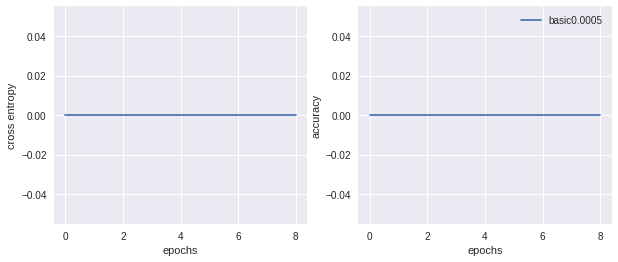

In [0]:
# PLOTTING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for filename in os.listdir(savedir):
    if filename.endswith('.pkl'):
        with open(os.path.join(savedir, filename),'rb') as fin:
            results = pickle.load(fin)
            ax1.plot(results['loss'])
            ax1.set_ylabel('cross entropy')
            ax1.set_xlabel('epochs')
            
            ax2.plot(results['accuracy'], label = filename[:-4])
            ax2.set_ylabel('accuracy')
            ax2.set_xlabel('epochs')
            
plt.legend()

In [0]:
class AwesomeNet(nn.Module):
    """The MNIST killer net."""
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 10)
    
    def forward(self, x):
        return self.fc(x.view(-1, 28*28))
    

In [0]:
# TRAINING
model = AwesomeNet()

lr = 0.005
optimizer = optim.Adam(model.parameters(), lr=lr)

results = {'name':'awesome', 'lr': lr, 'loss': [], 'accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 10):
    train(model, scratch_loader, optimizer, epoch)
    loss, acc = test(model, scratch_loader)
    
    # save results
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

NameError: ignored

If you want to learn more about Pytorch, here is a very comprehensive [tutorial](https://nbviewer.jupyter.org/github/ds4dm/tipsntricks/blob/master/pytorch/tutorial.ipynb) made by Mila for Mila. You are encouraged to look at it **after** this lab session.